## Methods to compare in integration tasks

Harmony and Liger are widely-used data integration / batch effect correction methods that have Python implementations. Harmony is usually considered to be less aggressive in strength, thus keeping more biological variance. Liger is suitable in situations with more severe batch effect.

In [1]:
import scanpy as sc
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
# Some utilities does not work on Windows. Consider using WSL2 on a Windows machine.
# Known probablematic ones: scib.me.clisi_graph
import scib

In [3]:
from tqdm import tqdm

In [4]:
import matplotlib as mpl

## Load data and view the data without integration

In [5]:
adata = sc.read_h5ad('output/human-brain-4000-integration.h5ad')

/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
with open("output/human-brain-4000-kuanglu-emb.pkl", 'rb') as f:
    adata.obsm['X_kuanglu'] = pkl.load(f)

## Scoring and plotting 

In [7]:
adata.obs.columns

Index(['global.x', 'global.y', 'adjusted.x', 'adjusted.y', 'fov.x', 'fov.y',
       'cluster_L1', 'cluster_L2', 'cluster_L3', 'sample'],
      dtype='object')

In [8]:
batch = 'sample'
label = 'cluster_L2'

In [9]:
ct = pd.crosstab(adata.obs[label], adata.obs[batch])
abundant_cell_types = ct.index[ct.min(axis=1) >= 3].tolist()
print(*abundant_cell_types, sep=', ')

eL2/3.IT, eL4/5.IT, eL5.IT, eL5/6.NP, eL6.IT, eL6.IT.CAR3, iLAMP5, iPVALB, iSST, iVIP, lASC, lMGC, lOGC, lOPC, oENDO, oMURAL


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


In [10]:
adata = adata[adata.obs[label].isin(abundant_cell_types)]

/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [11]:
methods = ('liger', 'harmony', 'pca', 'scanorama', 'kuanglu')
use_cosine = ['liger', 'scanorama']

In [12]:
scores = {}

for method in tqdm(methods):
    matrix_name = 'X_' + method
    
    if method in use_cosine:
        sc.pp.neighbors(adata, use_rep=matrix_name, metric='cosine')
    else:
        sc.pp.neighbors(adata, use_rep=matrix_name)
        
    s = skl.metrics.silhouette_score(adata.obsm[matrix_name], adata.obs[label])
    
    ilasw = scib.me.isolated_labels_asw(adata, batch_key=batch, label_key=label, embed=matrix_name)
    
    ilf1 = scib.me.isolated_labels_f1(adata, batch_key=batch, label_key=label, embed=None)
    
    db = skl.metrics.davies_bouldin_score(adata.obsm[matrix_name], adata.obs[label])
    ch = skl.metrics.calinski_harabasz_score(adata.obsm[matrix_name], adata.obs[label])
    clisi = scib.me.clisi_graph(adata, label_key=label, type_="knn")
    
    scores[method] = [s, ilasw, ilf1, db, ch, clisi]

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL2/3.IT: 0.4776314121657123


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL4/5.IT: 0.5888603492040041


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5.IT: 0.4793012378615607
eL5/6.NP: 0.5029141497348547


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT: 0.5394676600151418


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT.CAR3: 0.4490519616508454


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iLAMP5: 0.6372632602524164
iPVALB: 0.5619797639148957


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iSST: 0.6168934885671766
iVIP: 0.5446237963095577


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.646006574938282


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.6751145780976379
lOGC: 0.6482866114863602


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.7007018752923699
oENDO: 0.7193003832821029


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.5285639080549933
isolated labels: no more than 10 batches per label
eL2/3.IT: 0.5257482803495074


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL4/5.IT: 0.77338355304457


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5.IT: 0.5205047318611987


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5/6.NP: 0.14237668161434977


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT: 0.32069249793899424


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT.CAR3: 0.12091179385530228


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iLAMP5: 0.8624000000000002


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iPVALB: 0.6323768272874932


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iSST: 0.8709677419354839


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iVIP: 0.5844338297274516


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.9855397148676172


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.9450270098506515


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.9400942507068804


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.9613018964633522


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.9504416828866598


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.9166666666666667


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/minicon

isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL2/3.IT: 0.5125077301636338
eL4/5.IT: 0.5832285434007645


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5.IT: 0.5576516911387444


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5/6.NP: 0.6721300482749939


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT: 0.5429975613951683
eL6.IT.CAR3: 0.6353865414857864


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iLAMP5: 0.6719464212656021
iPVALB: 0.6146097257733345


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iSST: 0.5858701020479202
iVIP: 0.6033270582556725


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.6835101097822189
lMGC: 0.6665201336145401


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.7492241114377975


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.6503490656614304
oENDO: 0.6656014323234558


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.6283793151378632
isolated labels: no more than 10 batches per label
eL2/3.IT: 0.8385533184190901


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL4/5.IT: 0.8193069306930695


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5.IT: 0.8823809523809524


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5/6.NP: 0.977198697068404


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT: 0.5704584040747029


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT.CAR3: 0.976157082748948


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iLAMP5: 0.9330985915492959


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iPVALB: 0.9242424242424243


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iSST: 0.9048945483485873


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iVIP: 0.9144792548687553


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.9917270963129403


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.9688002573174654


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.986803623653613


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.9778621125869703


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.9701292911279535


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.9464508094645081


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/minicon

isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL2/3.IT: 0.5095157166942954
eL4/5.IT: 0.5397817343473434


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5.IT: 0.5253551676869392


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5/6.NP: 0.593684509396553


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT: 0.5463330149650574
eL6.IT.CAR3: 0.5684940665960312


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iLAMP5: 0.6136391833424568
iPVALB: 0.5736225619912148


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iSST: 0.546708669513464
iVIP: 0.561144195497036


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.6184441149234772
lMGC: 0.5848213508725166


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.6948746740818024


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.597138062119484
oENDO: 0.6023939028382301


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.5945307686924934
isolated labels: no more than 10 batches per label
eL2/3.IT: 0.4794202898550724


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL4/5.IT: 0.35736897643334503


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5.IT: 0.39348903043170563


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5/6.NP: 0.662280701754386


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT: 0.3600293901542983


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT.CAR3: 0.692167577413479


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iLAMP5: 0.6643757159221078


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iPVALB: 0.43561398267104867


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iSST: 0.5114022319262493


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iVIP: 0.4742138364779875


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.707890245503479


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.6814566764336543


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.5956893534030104


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.977310178729877


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.6303317535545023


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.7342271293375394


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/minicon

isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL2/3.IT: 0.4843042678375318
eL4/5.IT: 0.5090970580368792


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5.IT: 0.47831231254541684
eL5/6.NP: 0.5024330014736292


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT: 0.48299644917470824
eL6.IT.CAR3: 0.4933881251629686


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iLAMP5: 0.5357440440510604
iPVALB: 0.49350832365226394


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iSST: 0.48943950856563045
iVIP: 0.5081698788380475


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.559489298080735
lMGC: 0.5295519622889766


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.5838902672568299


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.5351280417451646
oENDO: 0.5166211672475958


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.5390041652964971
isolated labels: no more than 10 batches per label
eL2/3.IT: 0.5942282466112812


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL4/5.IT: 0.4753664984378755


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5.IT: 0.4105560032232071


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5/6.NP: 0.08667736757624399


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT: 0.23674796747967478


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT.CAR3: 0.1360544217687075


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iLAMP5: 0.6276243093922652


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iPVALB: 0.41082045184304405


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iSST: 0.39371804236669106


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iVIP: 0.42693236714975846


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.7031209021767638


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.5915929203539823


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.7197086936731908


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.6652253450856478


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.5812525583299223


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.7023761578735401


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/minicon

isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL2/3.IT: 0.5411810795153622
eL4/5.IT: 0.6200097092582064


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5.IT: 0.561235654259644
eL5/6.NP: 0.7007134563048407


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT: 0.5569465294948155
eL6.IT.CAR3: 0.6800096851302555


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iLAMP5: 0.6815221475140887
iPVALB: 0.611912962849229


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iSST: 0.577273415435193
iVIP: 0.5861502797278086


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.7189772102215366
lMGC: 0.7010569303086639


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.7358511301916895


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.6607940288823165
oENDO: 0.665610221135176


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.6727396978924284
isolated labels: no more than 10 batches per label
eL2/3.IT: 0.8930450029222677


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL4/5.IT: 0.8727876106194691


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5.IT: 0.8777648428405121


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL5/6.NP: 0.9607843137254902


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT: 0.8031939877876938


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


eL6.IT.CAR3: 0.9597701149425287


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iLAMP5: 0.9142367066895368


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iPVALB: 0.9104665825977302


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iSST: 0.8945956305097739


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


iVIP: 0.904384133611691


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.9897284653717076


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.969859554994477


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.9907180889336595


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.9779957248836917


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.9649201373339303


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.9441148922884794


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/minicon

In [13]:
scores = pd.DataFrame(scores, index=['silhouette', 'ilasw', 'ilf1', 'davies_bouldin', 'calinski_harabasz', 'cLISI']).T

In [14]:
scores = scores.loc[['kuanglu', 'scanorama', 'harmony', 'liger', 'pca']]
scores

,silhouette,ilasw,ilf1,davies_bouldin,calinski_harabasz,cLISI
kuanglu,0.347204,0.641999,0.926773,1.534629,8495.159659,0.999801
scanorama,0.079458,0.515067,0.485125,5.732919,1152.700512,0.998582
harmony,0.330652,0.626452,0.911409,1.720518,5696.958395,1.000000
liger,0.246534,0.582248,0.690804,2.383091,3662.876545,0.999614
pca,0.229626,0.579405,0.584829,2.272715,2899.189621,0.999857


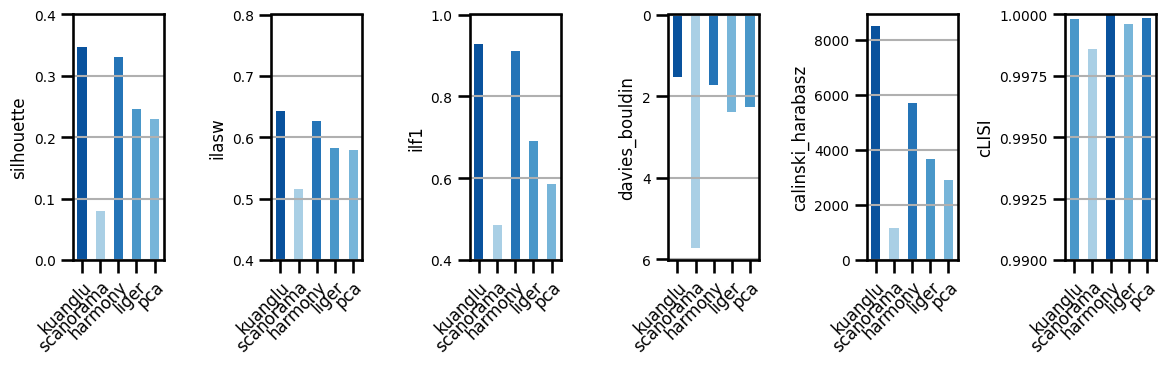

In [15]:
cmap = mpl.colormaps['Blues']
lower_is_better = ['davies_bouldin']
plt.subplots(1, scores.shape[1], figsize=(12, 4))
for i, v in enumerate(scores.columns):
    plt.subplot(1, scores.shape[1], i + 1)
    color = mpl.colormaps['Blues'](1 - scores[v].rank(ascending=v in lower_is_better, pct=True) * .66)
    scores[v].plot(kind='bar', color=color)
    plt.ylabel(v, size=12)
    plt.grid(axis='y')
    plt.yticks(size=10)
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=12)
    
    dmin = scores[v].min()
    dmax = scores[v].max()
    
    if dmin >= 0.0 and dmin <= 1.0 and dmax >= 0.0 and dmax <= 1.0:
        for vmin in [0.99, 0.8, 0.6, 0.4, 0.2, 0.0]:
            if dmin > vmin:
                break
        for vmax in [0.2, 0.4, 0.6, 0.8, 1.0]:
            if dmax < vmax:
                break
        plt.ylim(vmin, vmax)
        
    if v in lower_is_better:
        plt.gca().invert_yaxis()
    
plt.tight_layout()

In [16]:
batch_scores = {}


for method in tqdm(methods):
    matrix_name = 'X_' + method
    
    if method in use_cosine:
        sc.pp.neighbors(adata, use_rep=matrix_name, metric='cosine')
    else:
        sc.pp.neighbors(adata, use_rep=matrix_name)
    
    sb = scib.me.silhouette_batch(adata, batch_key=batch, label_key=label, embed=matrix_name)
        
    gcb = scib.me.graph_connectivity(adata, label_key=label)
    
    ilisi = scib.me.ilisi_graph(adata, batch_key=batch, type_="knn")
    
    # kbet = scib.me.kBET(adata, batch_key=batch, label_key=label, type_="embed", embed=matrix_name)
    
    batch_scores[method] = [sb, gcb, ilisi]

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

mean silhouette per group:              silhouette_score
group                        
eL2/3.IT             0.894048
eL4/5.IT             0.911822
eL5.IT               0.931736
eL5/6.NP             0.847078
eL6.IT               0.871487
eL6.IT.CAR3          0.835531
iLAMP5               0.933544
iPVALB               0.936521
iSST                 0.962203
iVIP                 0.930114
lASC                 0.941507
lMGC                 0.937212
lOGC                 0.913008
lOPC                 0.959679
oENDO                0.954574
oMURAL               0.889153


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:              silhouette_score
group                        
eL2/3.IT             0.906557
eL4/5.IT             0.928951
eL5.IT               0.942527
eL5/6.NP             0.903730
eL6.IT               0.938590
eL6.IT.CAR3          0.926982
iLAMP5               0.917311
iPVALB               0.933400
iSST                 0.955001
iVIP                 0.927024
lASC                 0.965066
lMGC                 0.957883
lOGC                 0.953156
lOPC                 0.934452
oENDO                0.968139
oMURAL               0.958840


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:              silhouette_score
group                        
eL2/3.IT             0.826768
eL4/5.IT             0.845367
eL5.IT               0.838672
eL5/6.NP             0.812099
eL6.IT               0.829830
eL6.IT.CAR3          0.836316
iLAMP5               0.890112
iPVALB               0.880183
iSST                 0.884978
iVIP                 0.893216
lASC                 0.903694
lMGC                 0.917605
lOGC                 0.867762
lOPC                 0.902945
oENDO                0.925119
oMURAL               0.920814


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:              silhouette_score
group                        
eL2/3.IT             0.897566
eL4/5.IT             0.910713
eL5.IT               0.889503
eL5/6.NP             0.864036
eL6.IT               0.889352
eL6.IT.CAR3          0.874940
iLAMP5               0.901200
iPVALB               0.901473
iSST                 0.917816
iVIP                 0.918046
lASC                 0.923383
lMGC                 0.953960
lOGC                 0.939352
lOPC                 0.941253
oENDO                0.938253
oMURAL               0.904956


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:              silhouette_score
group                        
eL2/3.IT             0.863532
eL4/5.IT             0.880003
eL5.IT               0.904163
eL5/6.NP             0.878556
eL6.IT               0.900480
eL6.IT.CAR3          0.877538
iLAMP5               0.888531
iPVALB               0.878689
iSST                 0.890132
iVIP                 0.903656
lASC                 0.935336
lMGC                 0.880766
lOGC                 0.848379
lOPC                 0.887486
oENDO                0.926231
oMURAL               0.927479


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

In [17]:
batch_scores = pd.DataFrame(batch_scores, index=['silhouette_batch', 'graph_connectivity_batch', 'ilisi']).T

In [18]:
batch_scores = batch_scores.loc[['kuanglu', 'scanorama', 'harmony', 'liger', 'pca']]
batch_scores

,silhouette_batch,graph_connectivity_batch,ilisi
kuanglu,0.891935,0.989277,0.374987
scanorama,0.910363,0.823436,0.173083
harmony,0.938601,0.993833,0.416207
liger,0.915576,0.958466,0.521915
pca,0.873467,0.995634,0.034193


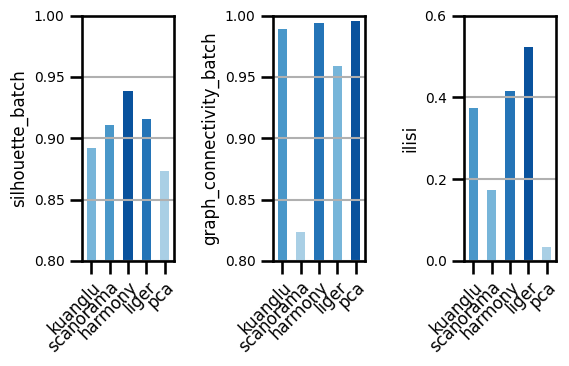

In [19]:
lower_is_better = [] # ['silhouette_batch', 'graph_connectivity_batch', 'ilisi']

plt.subplots(1, batch_scores.shape[1], figsize=(6, 4))
for i, v in enumerate(batch_scores.columns):
    plt.subplot(1, batch_scores.shape[1], i + 1)
    color = mpl.colormaps['Blues'](1 - batch_scores[v].rank(ascending=v in lower_is_better, pct=True) * .66)
    batch_scores[v].plot(kind='bar', color=color)
    plt.ylabel(v, size=12)
    plt.grid(axis='y')
    plt.yticks(size=10)
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=12)
    
    dmin = batch_scores[v].min()
    dmax = batch_scores[v].max()
    
    if dmin >= 0.0 and dmin <= 1.0 and dmax >= 0.0 and dmax <= 1.0:
        for vmin in [0.8, 0.6, 0.4, 0.2, 0.0]:
            if dmin > vmin:
                break
        for vmax in [0.2, 0.4, 0.6, 0.8, 1.0]:
            if dmax < vmax:
                break
        plt.ylim(vmin, vmax)
    
plt.tight_layout()

In [20]:
with open("output/human-brain-4000-judge-l2.pkl", 'wb') as f:
    pkl.dump([scores, batch_scores], f)